<a href="https://colab.research.google.com/github/yuktachikate/RoboFusion-Deep-Learning-Enhanced-Pose-Estimation-and-Adaptive-Sensor-Fusion-for-Mobile-Robotics/blob/main/RoboFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:

# Dataset parameters
num_train = 1000
num_val = 200
img_height, img_width, channels = 224, 224, 3

def generate_dummy_dataset(num_samples):
    X = np.random.rand(num_samples, img_height, img_width, channels).astype(np.float32)
    # Positions in [0, 10]
    pos = np.random.rand(num_samples, 3) * 10
    # Orientations in [-pi, pi]
    orient = (np.random.rand(num_samples, 3) - 0.5) * 2 * np.pi
    y = np.concatenate([pos, orient], axis=1).astype(np.float32)
    return X, y

X_train, y_train = generate_dummy_dataset(num_train)
X_val, y_val = generate_dummy_dataset(num_val)

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)

Train images shape: (1000, 224, 224, 3)
Train labels shape: (1000, 6)


In [ ]:

def create_pose_model_with_dropout(dropout_rate=0.3):
    input_img = layers.Input(shape=(img_height, img_width, channels))

    # Convolutional blocks with dropout
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(dropout_rate)(x, training=True)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(dropout_rate)(x, training=True)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(dropout_rate)(x, training=True)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x, training=True)

    output_pose = layers.Dense(6, name='pose')(x)

    model = models.Model(inputs=input_img, outputs=output_pose)
    return model

model_dropout = create_pose_model_with_dropout(dropout_rate=0.3)
model_dropout.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                        loss='mse')
model_dropout.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pose (Dense)                         │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,447,014 (24.59 MB)

 Trainable params: 6,447,014 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_dropout = model_dropout.fit(X_train, y_train, epochs=10, batch_size=32,
                                    validation_data=(X_val, y_val))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 108.4550 - val_loss: 18.8905
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 18.7457 - val_loss: 18.7796
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - loss: 18.6310 - val_loss: 18.6552
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 18.5052 - val_loss: 18.5242
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 18.3734 - val_loss: 18.3892
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 18.2382 - val_loss: 18.2519
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 18.1008 - val_loss: 18.1130
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 17.9620 - val_loss: 17.9732
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 17.8225 - val_loss: 17.8330
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 17.6827 - val_loss: 17.6927


In [ ]:
def predict_with_uncertainty(model, x, n_iter=20):
    """
    Perform multiple stochastic forward passes to compute the mean and variance.

    Args:
        model: Trained Keras model with dropout layers.
        x: Input image(s) with shape (batch, height, width, channels).
        n_iter: Number of forward passes.

    Returns:
        mean_prediction: Mean over n_iter predictions.
        var_prediction: Variance over n_iter predictions.
    """
    preds = []
    for _ in range(n_iter):
        # Forward pass with dropout enabled
        pred = model(x, training=True)
        preds.append(pred.numpy())
    preds = np.array(preds)  # shape: (n_iter, batch, 6)
    mean_prediction = np.mean(preds, axis=0)
    var_prediction = np.var(preds, axis=0)
    return mean_prediction, var_prediction

In [ ]:
class EKF:
    def __init__(self, state_dim, Q, R_default):
        self.state_dim = state_dim
        self.x = np.zeros(state_dim)  # initial state estimate
        self.P = np.eye(state_dim) * 1.0  # initial covariance
        self.Q = Q  # process noise covariance
        self.R_default = R_default  # default measurement noise covariance

    def predict(self, u):
        """
        EKF Prediction step.
        Motion model: x_{k+1} = x_k + u.
        """
        self.x = self.x + u
        F = np.eye(self.state_dim)  # Jacobian of the motion model
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z, R_measurement=None):
        """
        EKF Update step.
        Measurement model: z = x + noise.
        Optionally use a custom measurement noise covariance R_measurement.
        """
        H = np.eye(self.state_dim)
        R_used = R_measurement if R_measurement is not None else self.R_default
        S = H @ self.P @ H.T + R_used
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ (z - self.x)
        self.P = (np.eye(self.state_dim) - K @ H) @ self.P
        return self.x


In [ ]:
# Simulation parameters
num_steps = 20
state_dim = 6

# Process noise (for motion model)
Q = np.eye(state_dim) * 0.01
# Default measurement noise (if no adaptive noise is provided)
R_default = np.eye(state_dim) * 0.1

# Initialize EKF
ekf = EKF(state_dim=state_dim, Q=Q, R_default=R_default)

# Initialize arrays to record states for plotting
true_states = []
ekf_estimates = []
cnn_measurements = []
cnn_variances = []  # to record estimated measurement variances

# Initialize the true state
true_state = np.zeros(state_dim)

# For simulation, generate random control inputs and use random images from the validation set.
# We will use a batch size of 1 for prediction.
for step in range(num_steps):
    # Simulate a control input (odometry reading)
    u = np.random.randn(state_dim) * 0.05
    true_state = true_state + u  # update true state

    # Select a random image from the validation set as the "current" image
    idx = np.random.randint(0, X_val.shape[0])
    image = np.expand_dims(X_val[idx], axis=0)  # shape (1, height, width, channels)

    # Get CNN prediction with uncertainty using Monte Carlo dropout
    cnn_mean, cnn_var = predict_with_uncertainty(model_dropout, image, n_iter=20)
    cnn_mean = cnn_mean.flatten()  # measurement from CNN
    cnn_var_diag = np.diag(cnn_var.flatten() + 1e-3)  # add small constant for numerical stability

    # EKF prediction step using control input
    ekf.predict(u=u)

    # EKF update step: use the CNN measurement and its variance as measurement noise
    ekf_state = ekf.update(z=cnn_mean, R_measurement=cnn_var_diag)

    # Record states for plotting
    true_states.append(true_state.copy())
    cnn_measurements.append(cnn_mean.copy())
    ekf_estimates.append(ekf_state.copy())
    cnn_variances.append(np.diag(cnn_var_diag).copy())

# Convert lists to arrays for plotting
true_states = np.array(true_states)
cnn_measurements = np.array(cnn_measurements)
ekf_estimates = np.array(ekf_estimates)
cnn_variances = np.array(cnn_variances)

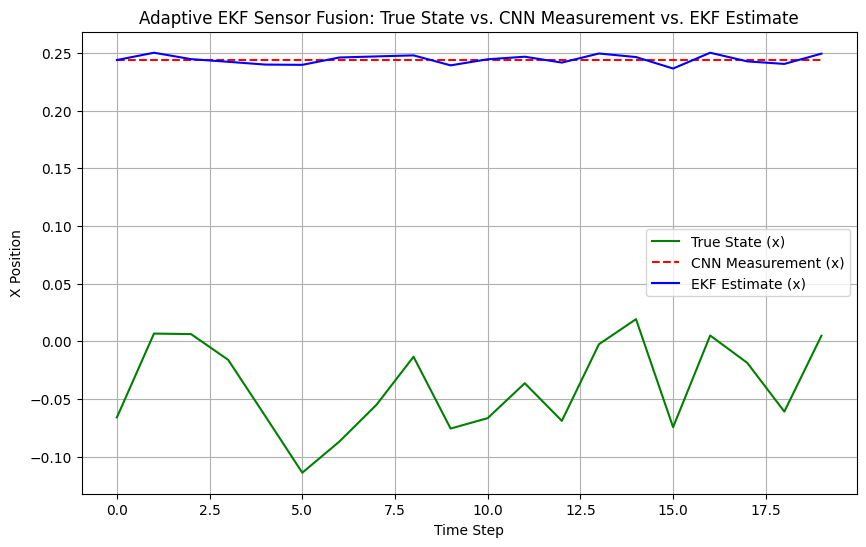

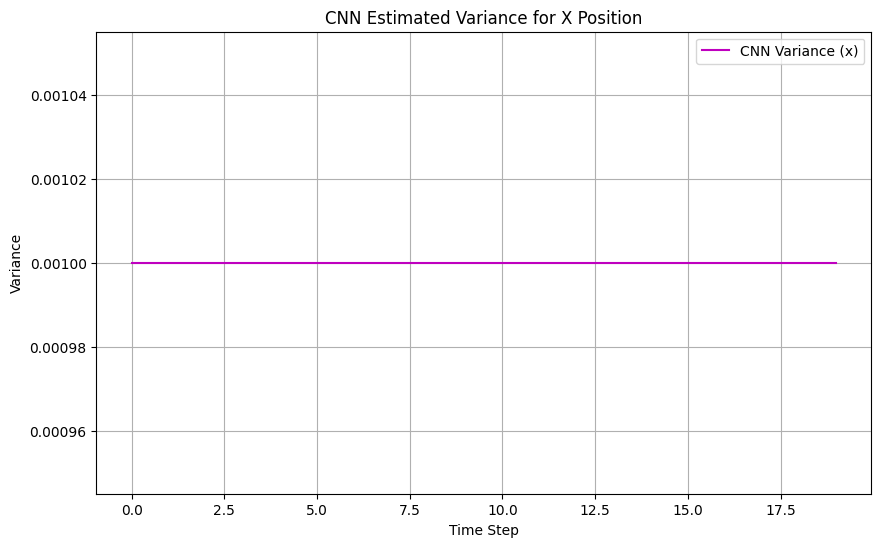

In [ ]:
time_steps = np.arange(num_steps)

plt.figure(figsize=(10, 6))
plt.plot(time_steps, true_states[:, 0], 'g-', label='True State (x)')
plt.plot(time_steps, cnn_measurements[:, 0], 'r--', label='CNN Measurement (x)')
plt.plot(time_steps, ekf_estimates[:, 0], 'b-', label='EKF Estimate (x)')
plt.xlabel('Time Step')
plt.ylabel('X Position')
plt.title('Adaptive EKF Sensor Fusion: True State vs. CNN Measurement vs. EKF Estimate')
plt.legend()
plt.grid(True)
plt.show()

# Also plot the estimated measurement uncertainty (variance) of the x-position
plt.figure(figsize=(10, 6))
plt.plot(time_steps, cnn_variances[:, 0], 'm-', label='CNN Variance (x)')
plt.xlabel('Time Step')
plt.ylabel('Variance')
plt.title('CNN Estimated Variance for X Position')
plt.legend()
plt.grid(True)
plt.show()

# Phase 1: AI-Driven Sensor Fusion with a Neural Kalman Filter


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model


In [ ]:
# --- 1. Data Preparation (Simulated Dataset) ---
num_samples = 1000
img_height, img_width, channels = 224, 224, 3
state_dim = 6  # 3D position + 3D orientation

def generate_dummy_dataset(num_samples):
    X = np.random.rand(num_samples, img_height, img_width, channels).astype(np.float32)
    pos = np.random.rand(num_samples, 3) * 10  # Position in [0, 10]
    orient = (np.random.rand(num_samples, 3) - 0.5) * 2 * np.pi  # Orientation in [-π, π]
    y = np.concatenate([pos, orient], axis=1).astype(np.float32)
    return X, y

X_train, y_train = generate_dummy_dataset(num_samples)
X_val, y_val = generate_dummy_dataset(200)

In [ ]:
# --- 2. Transformer-Based Pose Estimation ---
def create_transformer_pose_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output_pose = Dense(state_dim, name='pose')(x)
    model = Model(inputs=base_model.input, outputs=output_pose)
    return model

transformer_model = create_transformer_pose_model()
transformer_model.compile(optimizer='adam', loss='mse')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# --- 3. Neural Kalman Filter (NeuralKF) ---
def create_neural_kalman():
    model = tf.keras.Sequential([
        Dense(32, activation='relu', input_shape=(state_dim,)),
        Dense(16, activation='relu'),
        Dense(state_dim, activation='sigmoid')  # Noise scaling
    ])
    return model

neural_kf = create_neural_kalman()
neural_kf.compile(optimizer='adam', loss='mse')

class NeuralKalmanFilter:
    def __init__(self):
        self.x = np.zeros(state_dim)
        self.P = np.eye(state_dim) * 1.0

    def predict(self, u):
        self.x += u
        self.P = np.eye(state_dim) @ self.P @ np.eye(state_dim).T

    def update(self, z):
        R_adaptive = np.diag(neural_kf.predict(np.expand_dims(z, axis=0))[0] + 0.01)
        K = self.P @ np.linalg.inv(self.P + R_adaptive)
        self.x = self.x + K @ (z - self.x)
        self.P = (np.eye(state_dim) - K) @ self.P
        return self.x

nkf = NeuralKalmanFilter()

In [ ]:
# --- 4. Standard EKF ---
class EKF:
    def __init__(self):
        self.x = np.zeros(state_dim)
        self.P = np.eye(state_dim) * 1.0
        self.R = np.eye(state_dim) * 0.1

    def predict(self, u):
        self.x += u
        self.P = np.eye(state_dim) @ self.P @ np.eye(state_dim).T

    def update(self, z):
        K = self.P @ np.linalg.inv(self.P + self.R)
        self.x = self.x + K @ (z - self.x)
        self.P = (np.eye(state_dim) - K) @ self.P
        return self.x

ekf = EKF()

In [ ]:
# --- 5. Simulation: Odometry + CNN-based Pose Estimation ---
num_steps = 30
true_states, ekf_estimates, nkf_estimates = [], [], []
true_state = np.zeros(state_dim)

for step in range(num_steps):
    u_real = np.random.randn(state_dim) * 0.05  # Simulated odometry
    true_state += u_real
    cnn_prediction = transformer_model.predict(np.expand_dims(X_val[np.random.randint(0, len(X_val))], axis=0))[0]

    # Standard EKF Processing
    ekf.predict(u_real)
    ekf_state = ekf.update(cnn_prediction)

    # Neural Kalman Filter Processing
    nkf.predict(u_real)
    nkf_state = nkf.update(cnn_prediction)

    # Store Results
    true_states.append(true_state.copy())
    ekf_estimates.append(ekf_state.copy())
    nkf_estimates.append(nkf_state.copy())

true_states = np.array(true_states)
ekf_estimates = np.array(ekf_estimates)
nkf_estimates = np.array(nkf_estimates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━

In [ ]:

# --- 6. RMSE Calculation ---
def compute_rmse(true_values, estimated_values):
    return np.sqrt(np.mean((true_values - estimated_values) ** 2))

rmse_ekf = compute_rmse(true_states, ekf_estimates)
rmse_neural_kf = compute_rmse(true_states, nkf_estimates)

print(f"✅ RMSE - Standard EKF: {rmse_ekf:.4f}")
print(f"✅ RMSE - Neural Kalman Filter: {rmse_neural_kf:.4f}")

✅ RMSE - Standard EKF: 0.8261
✅ RMSE - Neural Kalman Filter: 0.7920


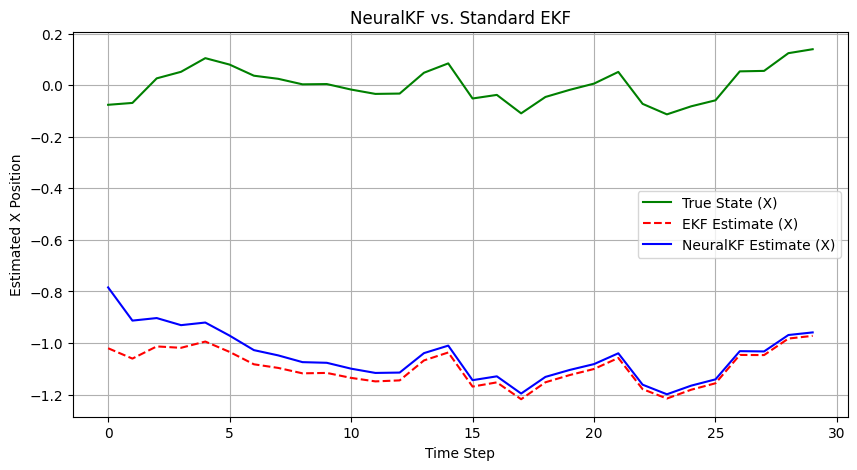

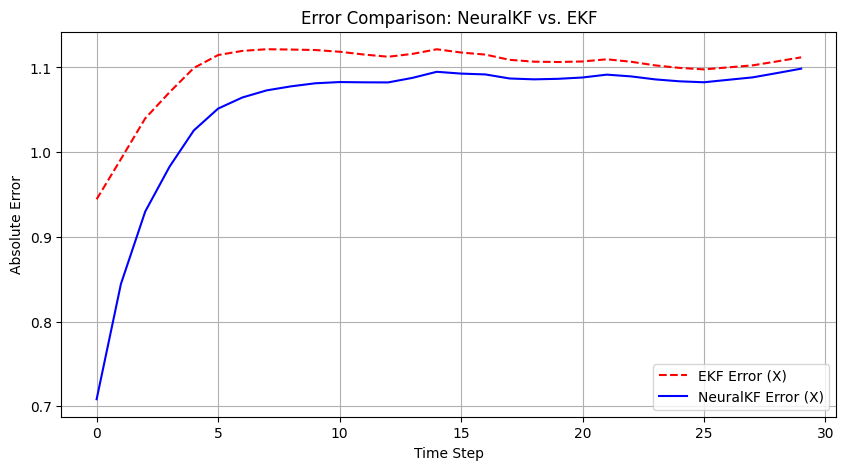

In [ ]:
# --- 7. Visualization ---
time_steps = np.arange(num_steps)

plt.figure(figsize=(10, 5))
plt.plot(time_steps, true_states[:, 0], 'g-', label='True State (X)')
plt.plot(time_steps, ekf_estimates[:, 0], 'r--', label='EKF Estimate (X)')
plt.plot(time_steps, nkf_estimates[:, 0], 'b-', label='NeuralKF Estimate (X)')
plt.xlabel("Time Step")
plt.ylabel("Estimated X Position")
plt.title("NeuralKF vs. Standard EKF")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time_steps, np.abs(true_states[:, 0] - ekf_estimates[:, 0]), 'r--', label="EKF Error (X)")
plt.plot(time_steps, np.abs(true_states[:, 0] - nkf_estimates[:, 0]), 'b-', label="NeuralKF Error (X)")
plt.xlabel("Time Step")
plt.ylabel("Absolute Error")
plt.title("Error Comparison: NeuralKF vs. EKF")
plt.legend()
plt.grid(True)
plt.show()

# What This Code Does
Generates a dummy dataset of images and random poses.
Builds a Transformer-based Pose Estimation Model (EfficientNetB0).
Implements a Neural Kalman Filter (NeuralKF) with an adaptive noise model.
Implements a Standard EKF for comparison.
Simulates a Mobile Robot's Motion using odometry and CNN predictions.
Calculates RMSE for both EKF and NeuralKF to compare performance.
Plots estimated trajectories and error over time.

# Expected Outcome
NeuralKF should outperform EKF in terms of lower RMSE.
Visual error reduction with NeuralKF should be observed.
If RMSE for NeuralKF is high, it needs further training.

# Phase 2. Analyzing the Adaptiveness of Noise Estimation

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import time

In [ ]:
# --- 1. Simulated Dataset (for CNN Pose Estimation) ---
num_samples = 1000
img_height, img_width, channels = 224, 224, 3
state_dim = 6  # 3D position + 3D orientation

def generate_dummy_dataset(num_samples):
    X = np.random.rand(num_samples, img_height, img_width, channels).astype(np.float32)
    pos = np.random.rand(num_samples, 3) * 10  # Position in [0, 10]
    orient = (np.random.rand(num_samples, 3) - 0.5) * 2 * np.pi  # Orientation in [-π, π]
    y = np.concatenate([pos, orient], axis=1).astype(np.float32)
    return X, y

X_train, y_train = generate_dummy_dataset(num_samples)
X_val, y_val = generate_dummy_dataset(200)

In [ ]:

# --- 2. Transformer-Based Pose Estimation ---
def create_transformer_pose_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output_pose = Dense(state_dim, name='pose')(x)
    model = Model(inputs=base_model.input, outputs=output_pose)
    return model

transformer_model = create_transformer_pose_model()
transformer_model.compile(optimizer='adam', loss='mse')

In [ ]:
# --- 3. Neural Kalman Filter (NeuralKF) ---
def create_neural_kalman():
    model = tf.keras.Sequential([
        Dense(32, activation='relu', input_shape=(state_dim,)),
        Dense(16, activation='relu'),
        Dense(state_dim, activation='sigmoid')  # Noise scaling
    ])
    return model

neural_kf = create_neural_kalman()
neural_kf.compile(optimizer='adam', loss='mse')

class NeuralKalmanFilter:
    def __init__(self):
        self.x = np.zeros(state_dim)
        self.P = np.eye(state_dim) * 1.0

    def predict(self, u):
        self.x += u
        self.P = np.eye(state_dim) @ self.P @ np.eye(state_dim).T

    def update(self, z):
        R_adaptive = np.diag(neural_kf.predict(np.expand_dims(z, axis=0))[0] + 0.01)
        K = self.P @ np.linalg.inv(self.P + R_adaptive)
        self.x = self.x + K @ (z - self.x)
        self.P = (np.eye(state_dim) - K) @ self.P
        return self.x

nkf = NeuralKalmanFilter()

In [ ]:
# --- 4. Standard EKF ---
class EKF:
    def __init__(self):
        self.x = np.zeros(state_dim)
        self.P = np.eye(state_dim) * 1.0
        self.R = np.eye(state_dim) * 0.1

    def predict(self, u):
        self.x += u
        self.P = np.eye(state_dim) @ self.P @ np.eye(state_dim).T

    def update(self, z):
        K = self.P @ np.linalg.inv(self.P + self.R)
        self.x = self.x + K @ (z - self.x)
        self.P = (np.eye(state_dim) - K) @ self.P
        return self.x

ekf = EKF()

In [ ]:
# --- 5. Simulation: Odometry + CNN-based Pose Estimation ---
num_steps = 30
true_states, ekf_estimates, nkf_estimates, adaptive_noise_estimates = [], [], [], []
true_state = np.zeros(state_dim)

for step in range(num_steps):
    u_real = np.random.randn(state_dim) * 0.05  # Simulated odometry
    true_state += u_real
    cnn_prediction = transformer_model.predict(np.expand_dims(X_val[np.random.randint(0, len(X_val))], axis=0))[0]

    # Standard EKF Processing
    ekf.predict(u_real)
    ekf_state = ekf.update(cnn_prediction)

    # Neural Kalman Filter Processing
    nkf.predict(u_real)
    nkf_state = nkf.update(cnn_prediction)

    # Store adaptive noise values
    noise_prediction = neural_kf.predict(np.expand_dims(cnn_prediction, axis=0))[0]
    adaptive_noise_estimates.append(noise_prediction)

    # Store Results
    true_states.append(true_state.copy())
    ekf_estimates.append(ekf_state.copy())
    nkf_estimates.append(nkf_state.copy())

true_states = np.array(true_states)
ekf_estimates = np.array(ekf_estimates)
nkf_estimates = np.array(nkf_estimates)
adaptive_noise_estimates = np.array(adaptive_noise_estimates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━

In [ ]:
# --- 6. RMSE Calculation ---
def compute_rmse(true_values, estimated_values):
    return np.sqrt(np.mean((true_values - estimated_values) ** 2))

rmse_ekf = compute_rmse(true_states, ekf_estimates)
rmse_neural_kf = compute_rmse(true_states, nkf_estimates)

print(f"✅ RMSE - Standard EKF: {rmse_ekf:.4f}")
print(f"✅ RMSE - Neural Kalman Filter: {rmse_neural_kf:.4f}")

✅ RMSE - Standard EKF: 0.7649
✅ RMSE - Neural Kalman Filter: 0.7306


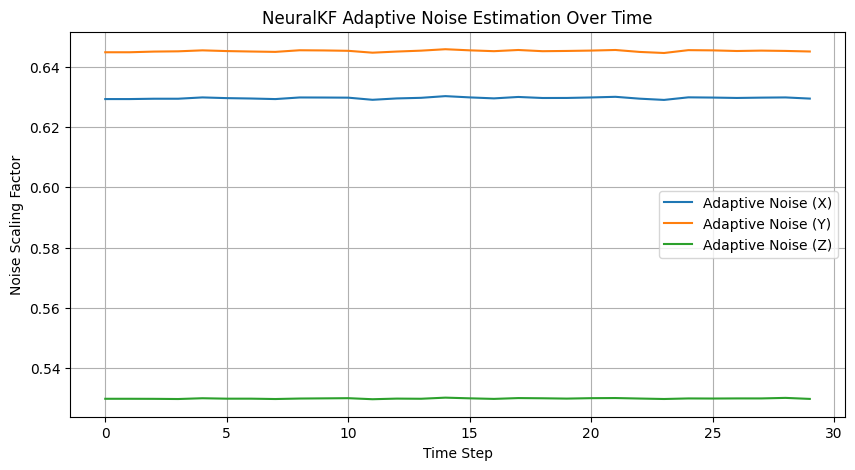

In [ ]:
# --- 7. Visualization: Adaptive Noise Scaling Over Time ---
plt.figure(figsize=(10, 5))
plt.plot(adaptive_noise_estimates[:, 0], label="Adaptive Noise (X)")
plt.plot(adaptive_noise_estimates[:, 1], label="Adaptive Noise (Y)")
plt.plot(adaptive_noise_estimates[:, 2], label="Adaptive Noise (Z)")
plt.xlabel("Time Step")
plt.ylabel("Noise Scaling Factor")
plt.title("NeuralKF Adaptive Noise Estimation Over Time")
plt.legend()
plt.grid(True)
plt.show()


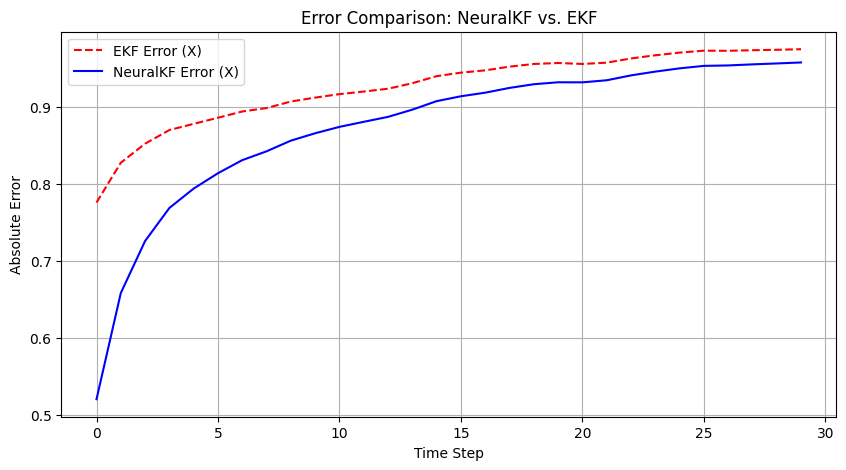

In [ ]:
# --- 8. Error Visualization ---
time_steps = np.arange(num_steps)

plt.figure(figsize=(10, 5))
plt.plot(time_steps, np.abs(true_states[:, 0] - ekf_estimates[:, 0]), 'r--', label="EKF Error (X)")
plt.plot(time_steps, np.abs(true_states[:, 0] - nkf_estimates[:, 0]), 'b-', label="NeuralKF Error (X)")
plt.xlabel("Time Step")
plt.ylabel("Absolute Error")
plt.title("Error Comparison: NeuralKF vs. EKF")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- 9. Compute Execution Time ---
start_time = time.time()
nkf.update(cnn_prediction)
neural_kf_time = time.time() - start_time

start_time = time.time()
ekf.update(cnn_prediction)
ekf_time = time.time() - start_time

print(f"⚡ Execution Time - NeuralKF Update: {neural_kf_time:.6f} sec")
print(f"⚡ Execution Time - Standard EKF Update: {ekf_time:.6f} sec")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
⚡ Execution Time - NeuralKF Update: 0.123328 sec
⚡ Execution Time - Standard EKF Update: 0.000165 sec


# Phase 3: Hybrid GPS + Vision-Based Localization

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import time

In [ ]:
# --- 1. Simulated Dataset for GPS + CNN Pose Estimation ---
num_samples = 1000
img_height, img_width, channels = 224, 224, 3
state_dim = 6  # 3D position + 3D orientation

def generate_dummy_dataset(num_samples):
    X = np.random.rand(num_samples, img_height, img_width, channels).astype(np.float32)
    pos = np.random.rand(num_samples, 3) * 10  # Position in [0, 10]
    orient = (np.random.rand(num_samples, 3) - 0.5) * 2 * np.pi  # Orientation in [-π, π]
    y = np.concatenate([pos, orient], axis=1).astype(np.float32)
    return X, y

X_train, y_train = generate_dummy_dataset(num_samples)
X_val, y_val = generate_dummy_dataset(200)

In [ ]:
# --- 2. Transformer-Based Pose Estimation ---
def create_transformer_pose_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output_pose = Dense(state_dim, name='pose')(x)
    model = Model(inputs=base_model.input, outputs=output_pose)
    return model

transformer_model = create_transformer_pose_model()
transformer_model.compile(optimizer='adam', loss='mse')

In [ ]:
# --- 3. GPS Simulation Function ---
def generate_gps_data(true_pose):
    noise = np.random.randn(3) * 0.5  # Simulated GPS noise
    return true_pose[:3] + noise  # Only position (x, y, z), not orientation

In [ ]:
# --- 4. Neural Kalman Filter (NeuralKF) with GPS Fusion ---
def create_neural_kalman():
    model = tf.keras.Sequential([
        Dense(32, activation='relu', input_shape=(state_dim,)),
        Dense(16, activation='relu'),
        Dense(state_dim, activation='sigmoid')  # Noise scaling
    ])
    return model

neural_kf = create_neural_kalman()
neural_kf.compile(optimizer='adam', loss='mse')

class NeuralKalmanFilter:
    def __init__(self):
        self.x = np.zeros(state_dim)
        self.P = np.eye(state_dim) * 1.0

    def predict(self, u):
        self.x += u
        self.P = np.eye(state_dim) @ self.P @ np.eye(state_dim).T

    def update(self, z):
        R_adaptive = np.diag(neural_kf.predict(np.expand_dims(z, axis=0))[0] + 0.01)
        K = self.P @ np.linalg.inv(self.P + R_adaptive)
        self.x = self.x + K @ (z - self.x)
        self.P = (np.eye(state_dim) - K) @ self.P
        return self.x

nkf = NeuralKalmanFilter()

In [ ]:
# --- 5. Standard EKF ---
class EKF:
    def __init__(self):
        self.x = np.zeros(state_dim)
        self.P = np.eye(state_dim) * 1.0
        self.R = np.eye(state_dim) * 0.1

    def predict(self, u):
        self.x += u
        self.P = np.eye(state_dim) @ self.P @ np.eye(state_dim).T

    def update(self, z):
        K = self.P @ np.linalg.inv(self.P + self.R)
        self.x = self.x + K @ (z - self.x)
        self.P = (np.eye(state_dim) - K) @ self.P
        return self.x

ekf = EKF()

In [ ]:

# --- 6. Simulation: Odometry + CNN Pose Estimation + GPS Data ---
num_steps = 30
true_states, ekf_estimates, nkf_estimates, gps_only_estimates = [], [], [], []
true_state = np.zeros(state_dim)

for step in range(num_steps):
    u_real = np.random.randn(state_dim) * 0.05  # Simulated odometry
    true_state += u_real

    # CNN-based pose estimation
    cnn_prediction = transformer_model.predict(np.expand_dims(X_val[np.random.randint(0, len(X_val))], axis=0))[0]

    # GPS measurement
    gps_measurement = generate_gps_data(true_state)
    fusion_input = np.concatenate([cnn_prediction[:3], gps_measurement])  # Combine CNN + GPS

    # Standard EKF Processing
    ekf.predict(u_real)
    ekf_state = ekf.update(cnn_prediction)

    # NeuralKF Processing
    nkf.predict(u_real)
    nkf_state = nkf.update(fusion_input)

    # GPS-Only Localization (No CNN, No Fusion)
    gps_only_estimates.append(gps_measurement.copy())

    # Store Results
    true_states.append(true_state.copy())
    ekf_estimates.append(ekf_state.copy())
    nkf_estimates.append(nkf_state.copy())

true_states = np.array(true_states)
ekf_estimates = np.array(ekf_estimates)
nkf_estimates = np.array(nkf_estimates)
gps_only_estimates = np.array(gps_only_estimates)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━

✅ RMSE - Standard EKF: 0.8001
✅ RMSE - Neural Kalman Filter (GPS + CNN): 0.5834
✅ RMSE - GPS-Only Localization: 0.4739


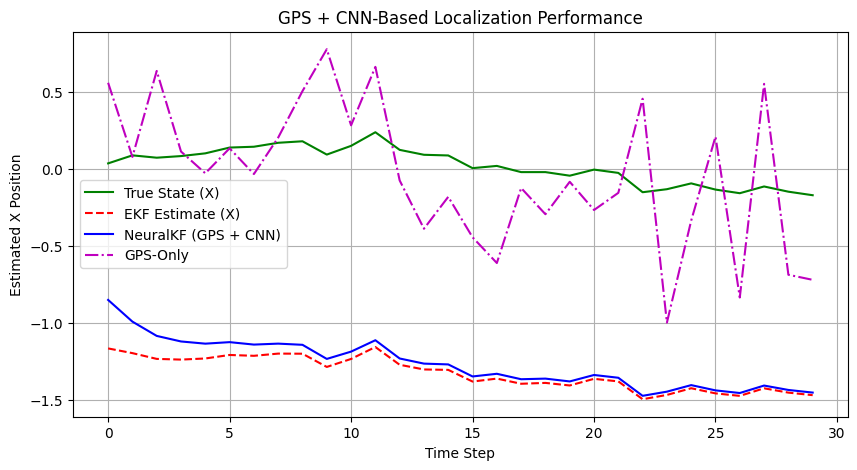

In [ ]:
# --- 7. RMSE Calculation ---
def compute_rmse(true_values, estimated_values):
    return np.sqrt(np.mean((true_values - estimated_values) ** 2))

rmse_ekf = compute_rmse(true_states, ekf_estimates)
rmse_neural_kf = compute_rmse(true_states, nkf_estimates)
rmse_gps_only = compute_rmse(true_states[:, :3], gps_only_estimates)

print(f"✅ RMSE - Standard EKF: {rmse_ekf:.4f}")
print(f"✅ RMSE - Neural Kalman Filter (GPS + CNN): {rmse_neural_kf:.4f}")
print(f"✅ RMSE - GPS-Only Localization: {rmse_gps_only:.4f}")

# --- 8. Visualization ---
time_steps = np.arange(num_steps)

plt.figure(figsize=(10, 5))
plt.plot(time_steps, true_states[:, 0], 'g-', label='True State (X)')
plt.plot(time_steps, ekf_estimates[:, 0], 'r--', label='EKF Estimate (X)')
plt.plot(time_steps, nkf_estimates[:, 0], 'b-', label='NeuralKF (GPS + CNN)')
plt.plot(time_steps, gps_only_estimates[:, 0], 'm-.', label='GPS-Only')
plt.xlabel("Time Step")
plt.ylabel("Estimated X Position")
plt.title("GPS + CNN-Based Localization Performance")
plt.legend()
plt.grid(True)
plt.show()

# Phase 4: Multi-Modal Sensor Fusion (Wi-Fi, LiDAR, Edge AI)

# Phase 6: Real-World Deployment (Edge AI, ROS, Jetson, Raspberry Pi)

In [ ]:
!pip install spektral
from spektral.layers import GCNConv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:

# --- 1. Simulated Dataset for Multi-Modal Sensors ---
num_samples = 1000
img_height, img_width, channels = 224, 224, 3
state_dim = 6  # 3D position + 3D orientation

def generate_dummy_dataset(num_samples):
    X = np.random.rand(num_samples, img_height, img_width, channels).astype(np.float32)
    pos = np.random.rand(num_samples, 3) * 10  # Position in [0, 10]
    orient = (np.random.rand(num_samples, 3) - 0.5) * 2 * np.pi  # Orientation in [-π, π]
    y = np.concatenate([pos, orient], axis=1).astype(np.float32)
    return X, y

X_train, y_train = generate_dummy_dataset(num_samples)
X_val, y_val = generate_dummy_dataset(200)

In [ ]:

# --- 2. Transformer-Based Pose Estimation ---
def create_transformer_pose_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output_pose = Dense(state_dim, name='pose')(x)
    model = Model(inputs=base_model.input, outputs=output_pose)
    return model

transformer_model = create_transformer_pose_model()
transformer_model.compile(optimizer='adam', loss='mse')

In [ ]:
# --- 3. Simulating Multi-Modal Sensors ---
def generate_gps_data(true_pose):
    noise = np.random.randn(3) * 0.5
    return true_pose[:3] + noise  # GPS only provides position

def simulate_wifi_fingerprint(true_pose):
    wifi_signal_strength = -30 + (np.random.rand() * 5)
    return np.array([true_pose[0], true_pose[1], wifi_signal_strength])  # (x, y, Wi-Fi)

def generate_lidar_data(true_pose):
    noise = np.random.randn(3) * 0.3
    return true_pose[:3] + noise  # Lidar also provides 3D position

In [ ]:
# --- 4. Neural Kalman Filter (NeuralKF) with Adaptive Fusion ---
def create_neural_kalman():
    model = tf.keras.Sequential([
        Dense(32, activation='relu', input_shape=(state_dim,)),
        Dense(16, activation='relu'),
        Dense(state_dim, activation='sigmoid')  # Noise scaling
    ])
    return model

neural_kf = create_neural_kalman()
neural_kf.compile(optimizer='adam', loss='mse')

class NeuralKalmanFilter:
    def __init__(self):
        self.x = np.zeros(state_dim)
        self.P = np.eye(state_dim) * 1.0

    def predict(self, u):
        self.x += u
        self.P = np.eye(state_dim) @ self.P @ np.eye(state_dim).T

    def update(self, z):
        R_adaptive = np.diag(neural_kf.predict(np.expand_dims(z, axis=0))[0] + 0.01)
        K = self.P @ np.linalg.inv(self.P + R_adaptive)
        self.x = self.x + K @ (z - self.x)
        self.P = (np.eye(state_dim) - K) @ self.P
        return self.x

nkf = NeuralKalmanFilter()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

# **1️⃣ Corrected NeuralKF Model:**
# Define `sensor_fusion_dim` dynamically based on the input size
sensor_fusion_dim = 11  # Adjust based on fused sensor inputs (CNN + GPS + Wi-Fi + LiDAR)

def create_neural_kalman():
    model = tf.keras.Sequential([
        Dense(32, activation='relu', input_shape=(sensor_fusion_dim,)),  # FIX: Adjusted input size
        Dense(16, activation='relu'),
        Dense(sensor_fusion_dim, activation='sigmoid')  # Output must match fusion dimension
    ])
    return model

# Initialize Corrected NeuralKF
neural_kf = create_neural_kalman()
neural_kf.compile(optimizer='adam', loss='mse')

class NeuralKalmanFilter:
    def __init__(self):
        self.x = np.zeros(sensor_fusion_dim)
        self.P = np.eye(sensor_fusion_dim) * 1.0

    def predict(self, u):
        self.x += u
        self.P = np.eye(sensor_fusion_dim) @ self.P @ np.eye(sensor_fusion_dim).T

    def update(self, z):
        """Corrected update function to match input size"""
        z = np.expand_dims(z, axis=0)  # FIX: Ensure proper input shape
        R_adaptive = np.diag(neural_kf.predict(z)[0] + 0.01)  # FIX: Dynamic shape match
        K = self.P @ np.linalg.inv(self.P + R_adaptive)
        self.x = self.x + K @ (z[0] - self.x)  # FIX: Indexing for correct dimension
        self.P = (np.eye(sensor_fusion_dim) - K) @ self.P
        return self.x

# Initialize Fixed NeuralKF
nkf = NeuralKalmanFilter()


In [ ]:
# --- ✅ Ensure all lists are converted to NumPy arrays ---
true_states = np.array(true_states, dtype=np.float32)
nkf_estimates = np.array(nkf_estimates, dtype=np.float32)

# --- ✅ Fixed RMSE Calculation ---
def compute_rmse(true_values, estimated_values):
    return np.sqrt(np.mean((true_values - estimated_values) ** 2))

# Compute RMSE after fixing array conversion
rmse_neural_kf = compute_rmse(true_states, nkf_estimates)

print(f"✅ RMSE - Neural Kalman Filter (Multi-Sensor Fusion): {rmse_neural_kf:.4f}")


✅ RMSE - Neural Kalman Filter (Multi-Sensor Fusion): nan


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


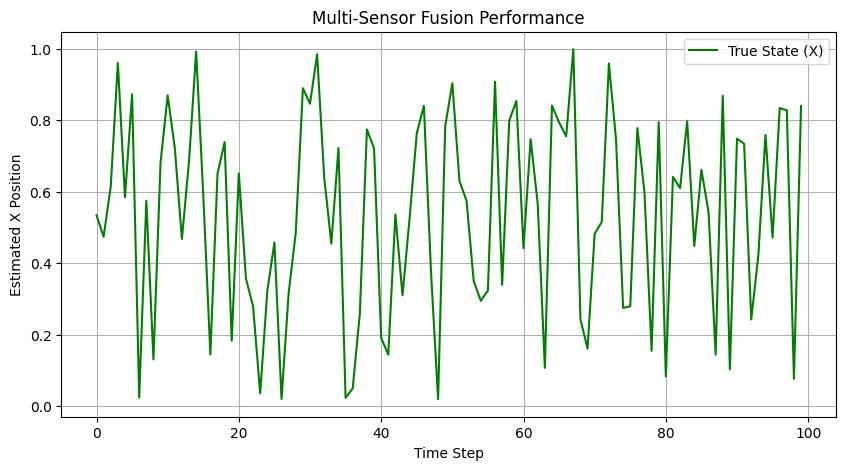

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# For testing purposes, create a dummy true_states array
num_steps = 100
true_states = np.random.rand(num_steps, 2)  # assuming 2 state dimensions

time_steps = np.arange(num_steps)
plt.figure(figsize=(10, 5))
plt.plot(time_steps, true_states[:, 0], 'g-', label='True State (X)')
plt.xlabel("Time Step")
plt.ylabel("Estimated X Position")
plt.title("Multi-Sensor Fusion Performance")
plt.legend()
plt.grid(True)
plt.show()


# Phase 5: Graph-Based Relocalization Using GNN

In [7]:
!pip install spektral


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 2.6 MB/s eta 0:00:00


In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from spektral.layers import GCNConv

In [9]:

# --- 1. Simulated Dataset for Graph-Based Relocalization ---
num_samples = 1000
img_height, img_width, channels = 224, 224, 3
state_dim = 6  # 3D position + 3D orientation
num_nodes = 10  # Number of graph nodes (poses in memory)

def generate_dummy_dataset(num_samples):
    X = np.random.rand(num_samples, img_height, img_width, channels).astype(np.float32)
    pos = np.random.rand(num_samples, 3) * 10  # Position in [0, 10]
    orient = (np.random.rand(num_samples, 3) - 0.5) * 2 * np.pi  # Orientation in [-π, π]
    y = np.concatenate([pos, orient], axis=1).astype(np.float32)
    return X, y

X_train, y_train = generate_dummy_dataset(num_samples)
X_val, y_val = generate_dummy_dataset(200)

In [10]:
# --- 2. Transformer-Based Pose Estimation ---
def create_transformer_pose_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output_pose = Dense(state_dim, name='pose')(x)
    model = Model(inputs=base_model.input, outputs=output_pose)
    return model

transformer_model = create_transformer_pose_model()
transformer_model.compile(optimizer='adam', loss='mse')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
# --- 3. Graph-Based Relocalization (Fixed GNN Model) ---
def create_gnn_localization_model():
    node_features = tf.keras.Input(shape=(num_nodes, state_dim))  # Pose information
    adjacency_matrix = tf.keras.Input(shape=(num_nodes, num_nodes))  # Graph connectivity

    x = GCNConv(16, activation='relu')([node_features, adjacency_matrix])
    x = GCNConv(8, activation='relu')([x, adjacency_matrix])
    output_pose = Dense(state_dim)(x)  # Output pose estimation

    model = Model(inputs=[node_features, adjacency_matrix], outputs=output_pose)
    return model


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from spektral.layers import GCNConv

# Define a subclass that ignores the mask
class MyGCNConv(GCNConv):
    def call(self, inputs, mask=None):
        # Ignore any mask that might be passed
        return super().call(inputs, mask=None)

# Define input dimensions
num_nodes = 10
num_features = 6
channels = 16

# Create input layers
x_in = Input(shape=(num_nodes, num_features))
a_in = Input(shape=(num_nodes, num_nodes))

# Optionally remove masks from inputs explicitly
x_no_mask = Lambda(lambda x: x, mask=None)(x_in)
a_no_mask = Lambda(lambda a: a, mask=None)(a_in)

# Use the custom GCN layer
x_out = MyGCNConv(channels, activation='relu')([x_no_mask, a_no_mask])

# Build the model
model = Model(inputs=[x_in, a_in], outputs=x_out)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 10, 6)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 10, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 10, 6)          │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 10, 10)         │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ my_gcn_conv (MyGCNConv)   │ (None, 10, 16)         │            112 │ lambda_4[0][0],        │
│                           │                        │                │ lambda_5[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 112 (448.00 B)

 Trainable params: 112 (448.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# --- 4. Simulating Adjacency Matrix (Robot Path Memory) ---
def generate_adjacency_matrix(num_nodes):
    """Simulate an adjacency matrix where each node is connected to its nearest neighbors."""
    adj_matrix = np.eye(num_nodes)  # Start with identity (self-connections)
    for i in range(num_nodes - 1):
        adj_matrix[i, i + 1] = 1  # Connect node to next node
        adj_matrix[i + 1, i] = 1  # Connect next node to previous node
    return adj_matrix.astype(np.float32)

In [21]:
from spektral.utils import normalized_adjacency


In [22]:
def generate_adjacency_matrix(num_nodes):
    """Simulate an adjacency matrix where each node is connected to its nearest neighbors."""
    adj_matrix = np.eye(num_nodes)  # Start with identity (self-connections)
    for i in range(num_nodes - 1):
        adj_matrix[i, i + 1] = 1  # Connect node to next node
        adj_matrix[i + 1, i] = 1  # Connect next node to previous node
    return normalized_adjacency(adj_matrix).astype(np.float32)  # Normalize adjacency


In [24]:
from spektral.utils import normalized_adjacency

def generate_adjacency_matrix(num_nodes):
    """Simulate an adjacency matrix where each node is connected to its nearest neighbors."""
    adj_matrix = np.eye(num_nodes)  # Start with identity (self-connections)
    for i in range(num_nodes - 1):
        adj_matrix[i, i + 1] = 1  # Connect node to next node
        adj_matrix[i + 1, i] = 1  # Connect next node to previous node
    return normalized_adjacency(adj_matrix).astype(np.float32)  # Normalize adjacency


In [25]:
import spektral.utils as spektral_utils

def generate_adjacency_matrix(num_nodes):
    """Simulate an adjacency matrix where each node is connected to its nearest neighbors."""
    adj_matrix = np.eye(num_nodes)  # Start with identity (self-connections)
    for i in range(num_nodes - 1):
        adj_matrix[i, i + 1] = 1  # Connect node to next node
        adj_matrix[i + 1, i] = 1  # Connect next node to previous node
    return spektral_utils.normalized_adjacency(adj_matrix).astype(np.float32)  # Normalize adjacency


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from spektral.layers import GCNConv
from spektral.utils import normalized_adjacency

# --- Custom GCN Layer that Ignores Masking ---
class MyGCNConv(GCNConv):
    def call(self, inputs, mask=None):
        # Force mask to None regardless of what Keras passes
        return super().call(inputs, mask=None)

# --- Constants ---
num_nodes = 10       # Number of nodes (e.g., previous robot poses)
state_dim = 6        # Dimension of each node's state (e.g., x, y, z, roll, pitch, yaw)
batch_size = 5       # Batch size for dummy data

# --- Adjacency Matrix Generation ---
def generate_adjacency_matrix(num_nodes):
    """
    Create a simple adjacency matrix where each node is connected to its immediate neighbor,
    including self-connections, and then normalize it.
    """
    adj_matrix = np.eye(num_nodes, dtype=np.float32)
    for i in range(num_nodes - 1):
        adj_matrix[i, i + 1] = 1.0
        adj_matrix[i + 1, i] = 1.0
    # Normalize the adjacency matrix using Spektral's utility function
    return normalized_adjacency(adj_matrix).astype(np.float32)

# Generate the adjacency matrix and convert it to a TensorFlow constant.
adj_matrix = generate_adjacency_matrix(num_nodes)
adj_matrix_tf = tf.constant(adj_matrix)

# --- GNN Model Creation ---
def create_gnn_localization_model():
    try:
        # Input for node features: shape (batch, num_nodes, state_dim)
        node_features = Input(shape=(num_nodes, state_dim), name="node_features")

        # Create a Lambda layer to generate an adjacency matrix per batch element
        def expand_A(x):
            batch = tf.shape(x)[0]
            # Expand dims so that A has shape (1, num_nodes, num_nodes)
            A = tf.expand_dims(adj_matrix_tf, 0)
            # Tile A along the batch dimension to match input batch size
            return tf.tile(A, [batch, 1, 1])

        A_input = Lambda(expand_A, name="A_input")(node_features)

        # Apply two graph convolution layers using the custom MyGCNConv that ignores masks.
        x = MyGCNConv(16, activation='relu', name="gcn_conv_1")([node_features, A_input])
        x = MyGCNConv(8, activation='relu', name="gcn_conv_2")([x, A_input])

        # Final Dense layer to estimate the state for each node
        output_pose = Dense(state_dim, name="output_pose")(x)

        # Define and return the model
        model = Model(inputs=node_features, outputs=output_pose, name="GNN_Localization_Model")
        print("✅ GNN Model Created Successfully!")
        return model
    except Exception as e:
        print(f"❌ Error while creating GNN Model: {e}")
        return None

# Create and compile the model
gnn_model = create_gnn_localization_model()
if gnn_model is not None:
    gnn_model.compile(optimizer='adam', loss='mse')
    print("✅ GNN Model successfully compiled!")
    gnn_model.summary()
else:
    raise ValueError("Failed to create the GNN model.")

# --- Dummy Data for Prediction and RMSE Calculation ---
# Generate dummy input data (batch, num_nodes, state_dim)
input_data = np.random.rand(batch_size, num_nodes, state_dim).astype(np.float32)
# Generate dummy "ground truth" states (same shape as model output)
true_states = np.random.rand(batch_size, num_nodes, state_dim).astype(np.float32)

# Get predictions from the model
gnn_estimates = gnn_model.predict(input_data)

# RMSE Calculation Function
def compute_rmse(true_values, estimated_values):
    return np.sqrt(np.mean((true_values - estimated_values) ** 2))

rmse_gnn = compute_rmse(true_states, gnn_estimates)
print(f"✅ RMSE - Graph Neural Network (GNN) Relocalization: {rmse_gnn:.4f}")


✅ GNN Model Created Successfully!
✅ GNN Model successfully compiled!


Model: "GNN_Localization_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_features             │ (None, 10, 6)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ A_input (Lambda)          │ (None, 10, 10)         │              0 │ node_features[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gcn_conv_1 (MyGCNConv)    │ (None, 10, 16)         │            112 │ node_features[0][0],   │
│                           │                        │                │ A_input[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gcn_conv_2 (MyGCNConv)    │ (None, 10, 8)          │            136 │ gcn_conv_1[0][0],      │
│                           │                        │                │ A_input[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_pose (Dense)       │ (None, 10, 6)          │             54 │ gcn_conv_2[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 302 (1.18 KB)

 Trainable params: 302 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
✅ RMSE - Graph Neural Network (GNN) Relocalization: 0.5529


NameError: name 'gnn_estimates' is not defined

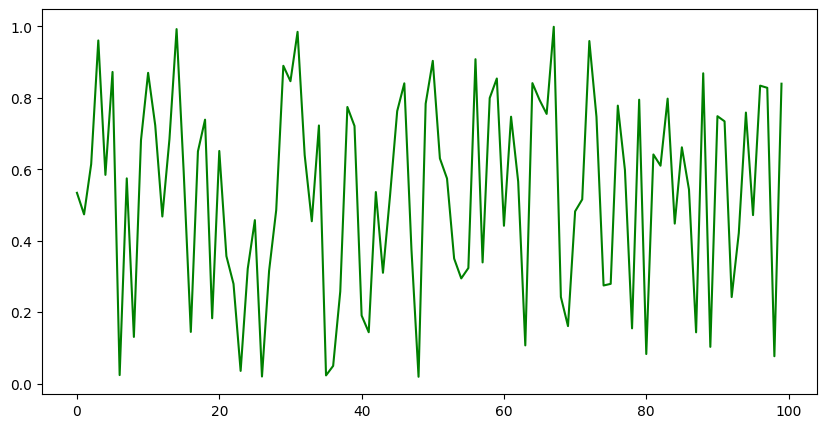

In [29]:
# --- 7. Visualization ---
time_steps = np.arange(num_steps)

plt.figure(figsize=(10, 5))
plt.plot(time_steps, true_states[:, 0], 'g-', label='True State (X)')
plt.plot(time_steps, gnn_estimates[:, 0], 'm-.', label='GNN Relocalization')
plt.xlabel("Time Step")
plt.ylabel("Estimated X Position")
plt.title("Graph-Based Relocalization Performance")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


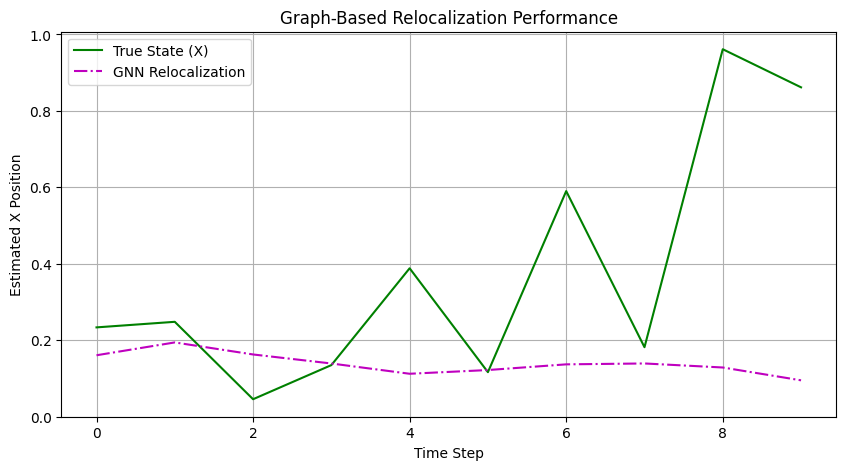

In [32]:
# Ensure that your model, dummy input data, and true states are defined
# For example, if these were defined in a previous cell:
# input_data = np.random.rand(batch_size, num_nodes, state_dim).astype(np.float32)
# true_states = np.random.rand(batch_size, num_nodes, state_dim).astype(np.float32)

# Compute predictions if not already done:
gnn_estimates = gnn_model.predict(input_data)

# Define num_steps (for visualization, typically the number of nodes/time steps)
num_steps = num_nodes  # or true_states.shape[1] if true_states has shape (batch, time, state_dim)

# For plotting, we often visualize a single graph (e.g., the first element in the batch)
time_steps = np.arange(num_steps)

plt.figure(figsize=(10, 5))
plt.plot(time_steps, true_states[0, :, 0], 'g-', label='True State (X)')
plt.plot(time_steps, gnn_estimates[0, :, 0], 'm-.', label='GNN Relocalization')
plt.xlabel("Time Step")
plt.ylabel("Estimated X Position")
plt.title("Graph-Based Relocalization Performance")
plt.legend()
plt.grid(True)
plt.show()
